In [1]:
devtools::install_github("ClairBarnes/rwwa")
suppressMessages(library("rwwa"))

Skipping install of 'rwwa' from a github remote, the SHA1 (533d8a6e) has not changed since last install.
  Use `force = TRUE` to force installation



In [12]:
ba = read.csv("data/ba-px_pantanal_modis-80.csv")
fwi = read.csv("data/fwi_pantanal_era5.csv")

In [13]:
df = merge(ba, fwi)
df$dsr <- (0.0272 * (df$fwi ^ 1.71))
df$log_ba <- log(df$ba)

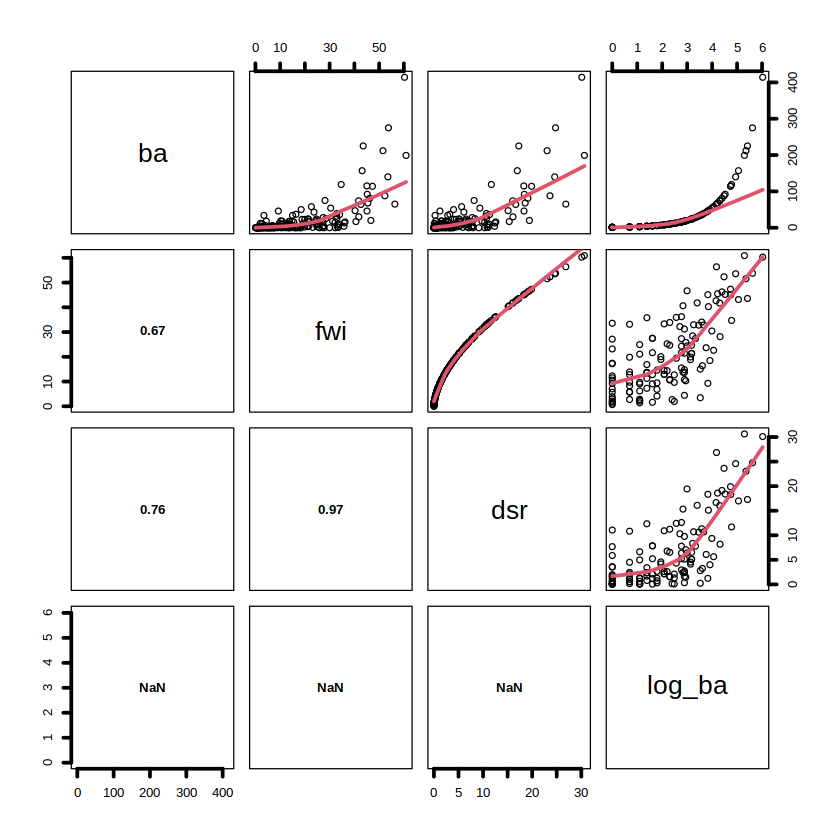

In [15]:
pairs(df[substr(df$time,1,4) == "2024",-1], lower.panel = panel.cor, upper.panel = panel.smooth, lwd = 3)

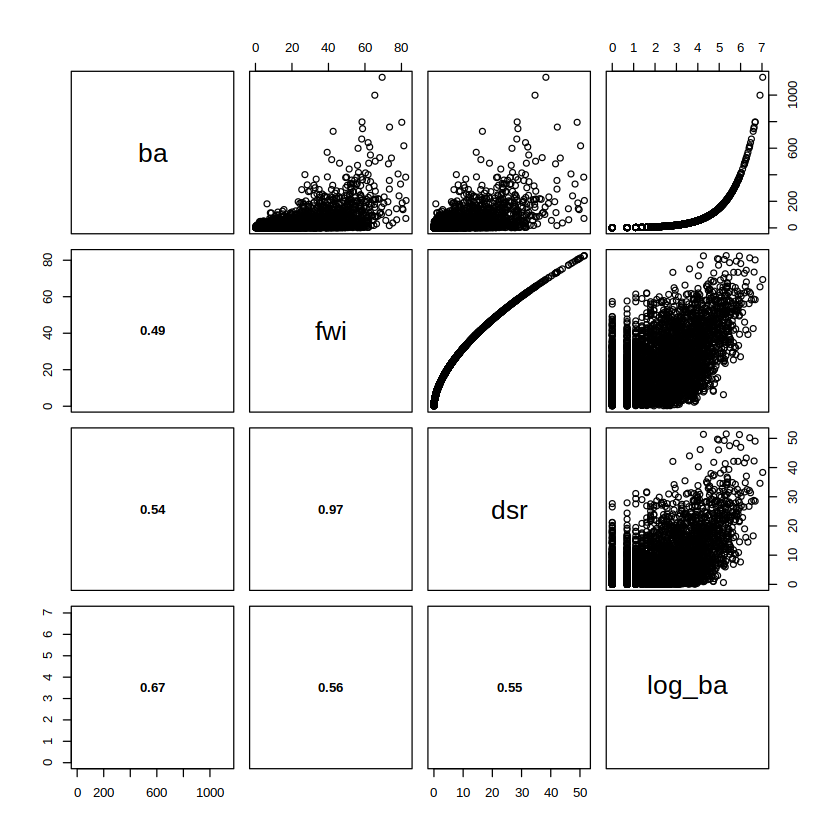

In [5]:
pairs(df[df$ba > 0,-1], lower.panel = panel.cor)

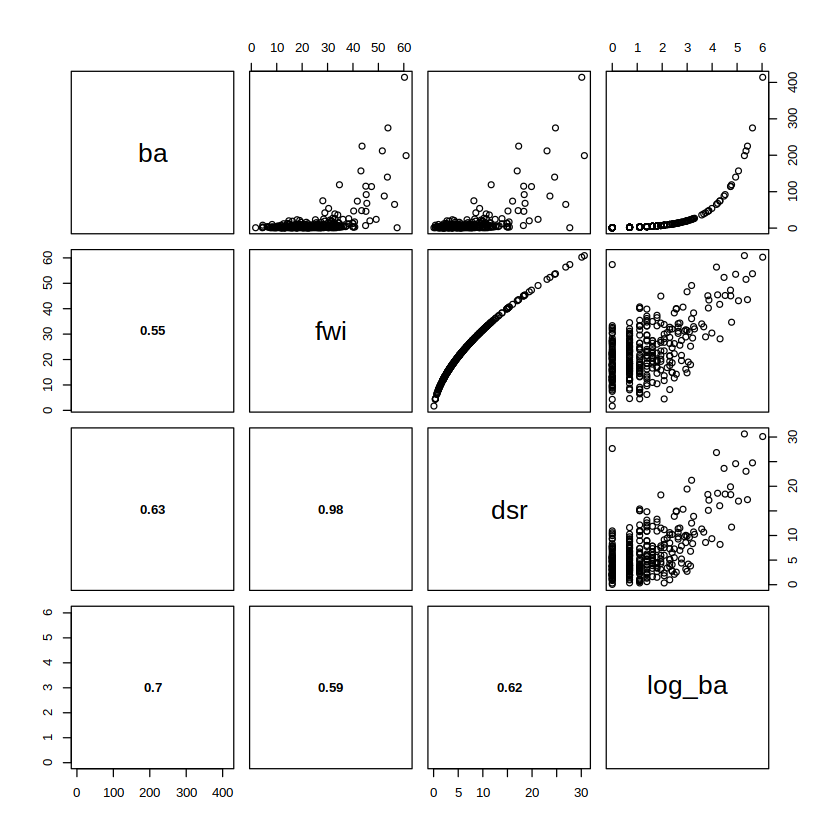

In [6]:
pairs(df[(df$ba > 0) & (substr(df$time,6,7) == "06"),-1], lower.panel = panel.cor)

# June FWI or 15-day FWI?

In [7]:
df$fwi30 = filter(df$fwi, rep(1/30,30), sides = 1)
df$ba30 = filter(df$ba, rep(1/30,30), sides = 1)
df$dsr30 = filter(df$dsr, rep(1/30,30), sides = 1)


df$fwi15 = filter(df$fwi, rep(1/15,15), sides = 1)
df$ba15 = filter(df$ba, rep(1/15,15), sides = 1)

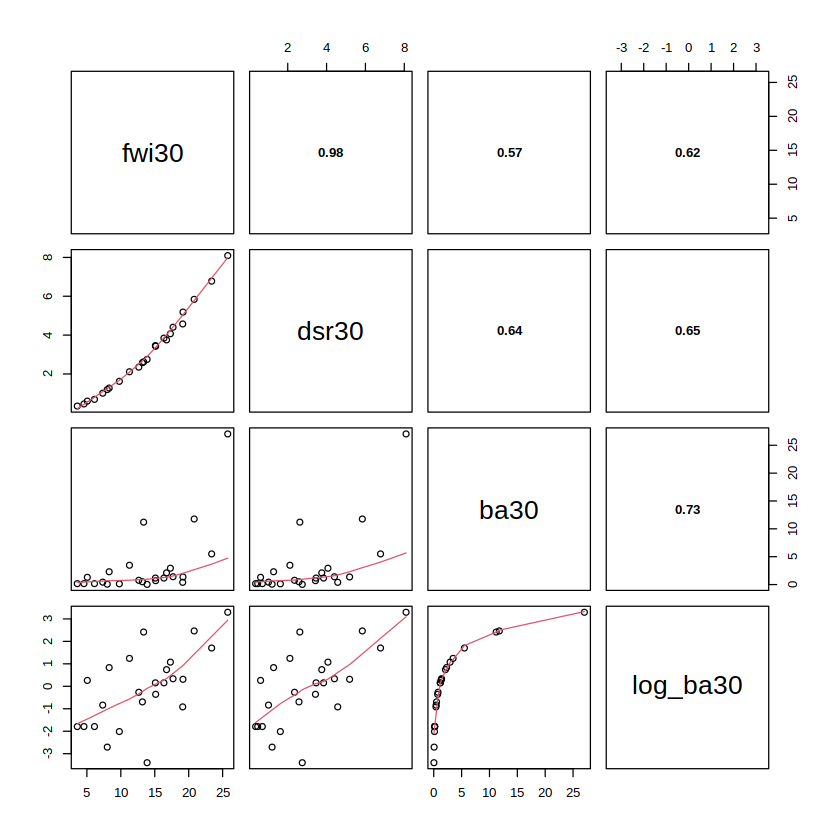

In [8]:
df_june = df[substr(df$time,6,10) == "06-13",c("time", "fwi30", "dsr30", "ba30")]
df_june$log_ba30 = log(df_june$ba30)

pairs(df_june[,-1], upper.panel = panel.cor, lower.panel = panel.smooth)

In [191]:
prep_window(c(1,1))

png("fig/fwi-ba.png", width = 360 * 2, height = 360); {
    prep_window(c(1,2))

    plot(df_june$fwi, df_june$log_ba30, pch = 20, xlab = "June mean FWI", ylab = "log(active fire area in June)", 
         main = paste0("FWI: correlation ", round(cor(df_june$fwi, df_june$log_ba30), 2)))
    lines(lowess(df_june$fwi, df_june$log_ba30), col = "red3")
    abline(line(df_june$fwi, df_june$log_ba30), col = "blue3") 
    legend("topleft", c("Loess smoother", "Linear fit"), col = c("red3", "blue3"), lty = 1)

    plot(df_june$dsr, df_june$log_ba30, pch = 20, xlab = "June mean DSR", ylab = "log(active fire area in June)", 
         main = paste0("DSR: correlation ", round(cor(df_june$dsr, df_june$log_ba30), 2)))
    lines(lowess(df_june$dsr, df_june$log_ba30), col = "red3")
    abline(line(df_june$dsr, df_june$log_ba30), col = "blue3") 
    legend("topleft", c("Loess smoother", "Linear fit"), col = c("red3", "blue3"), lty = 1)
}; dev.off()

png 
  2

In [151]:
df_15d <- df[substr(df$time,6,10) <= "07-15", c("time", "fwi15", "ba15")]
df_15d <- df_15d[!is.na(df_15d$ba15),]

df_15d <- rbind.fill(sapply(2001:2024, function(y) {
    df_y = df_15d[substr(df_15d$time,1,4) == y,]
    df_y[which.max(df_y$fwi),,drop = F]
}, simplify = F))

In [152]:
df_15d$year <- substr(df_15d$time,1,4)
df_june$year <- substr(df_june$time,1,4)
df_15d$log_ba15 <- log(df_15d$ba15)

In [153]:
df_15d <- merge(df_15d, df_june[,c("year", "ba30", "log_ba30")])

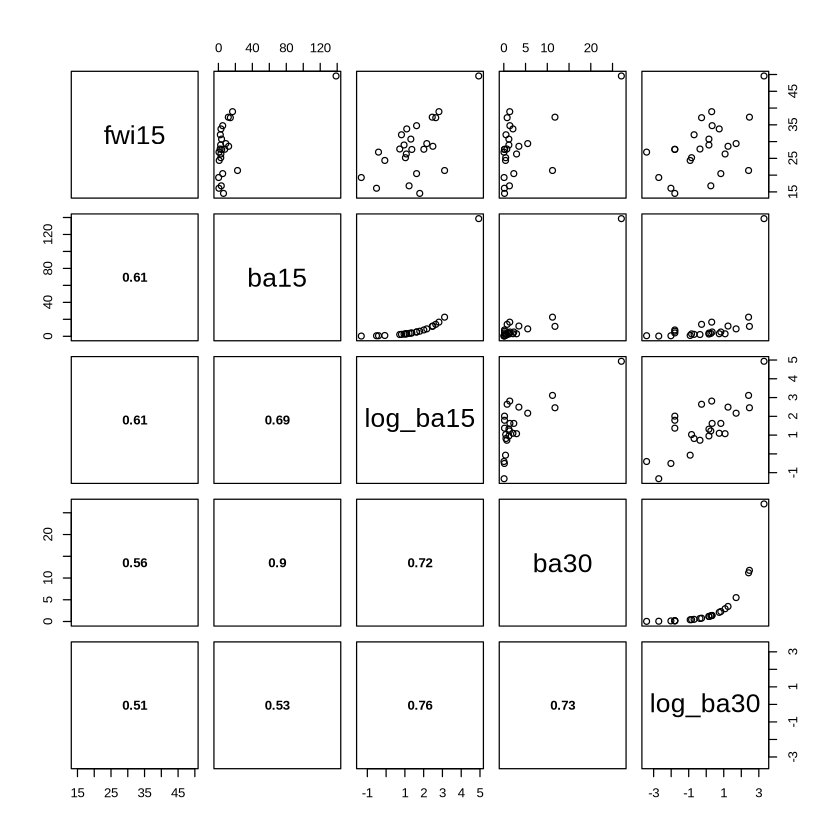

In [155]:
pairs(df_15d[,-(1:2)], lower.panel = panel.cor)

# Trend fitting

In [155]:
fwi <- load_ts("ts_obs/pantanal-fires_fwi-june_era5.dat", col.names = c("year", "fwi"))
dsr <- load_ts("ts_obs/pantanal-fires_dsr-june_era5.dat", col.names = c("year", "dsr"))

nino <- load_ts("ts_obs//pantanal-fires_nino-djf_ersst.dat", col.names = c("year", "nino"))

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

df <- merge(merge(merge(gmst, nino), fwi), dsr)

df$log_fwi <- log(df$fwi)
df$log_dsr <- log(df$dsr)

In [156]:
png("fig/fitted-trend-gmst-only.png", height = 360, width = 540); {
    prep_window(c(1,1))

    plot_trend(fit_ns("norm", "shift", df, "fwi", c("gmst")), add_loess = T)
}; dev.off()

png 
  2

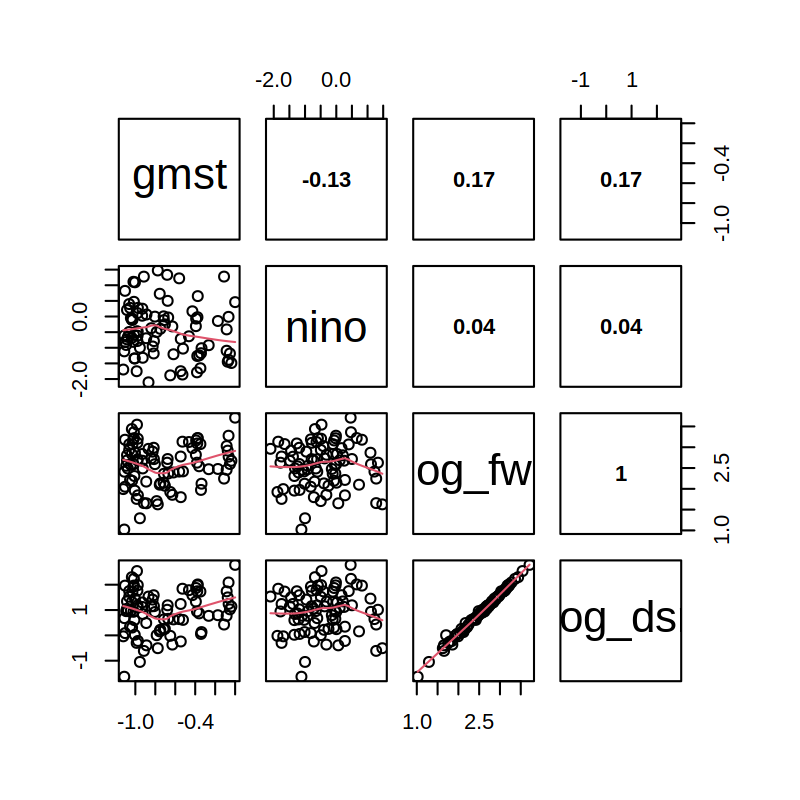

In [157]:
pairs(df[,c("gmst", "nino", "log_fwi", "log_dsr")], lower.panel = panel.smooth, upper.panel = panel.cor)

In [158]:
models <- list("FWI (GMST only)" = fit_ns("norm", "shift", df, "fwi", c("gmst")),
                "log FWI (GMST only)" = fit_ns("norm", "shift", df, "log_fwi", c("gmst")),
                "DSR (GMST only)" = fit_ns("norm", "shift", df, "dsr", c("gmst")),
                "log DSR (GMST only)" = fit_ns("norm", "shift", df, "log_dsr", c("gmst")))

# best fit when using only GMST as a covariate seems to be log FWI

In [159]:
sapply(models, rsquared) * 100

,FWI (GMST only),log FWI (GMST only),DSR (GMST only),log DSR (GMST only)
r2,2.184401,2.921022,1.9613124,2.875783
r2.adj,1.005900,1.751395,0.7801234,1.705612


# Nino 'broken stick' model

In [160]:
df$npos <- df$nneg <- df$nino
df$npos[df$npos < 0] <- 0; df$nneg[df$nneg > 0] <- 0

In [161]:
# df <- df[df$year >= 1970,]

In [163]:
mdl_nino <- list("gmst only" = fit_ns("norm", "shift", df, "log_fwi", c("gmst")),
                 "symmetric" = fit_ns("norm", "shift", df, "log_fwi", c("gmst", "nino")),
                 "asymmetric" = fit_ns("norm", "shift", df, "log_fwi", c("gmst", "nneg", "npos")),
                 "nino_pos" = fit_ns("norm", "shift", df, "log_fwi", c("gmst", "npos")),
                 "nino_neg" = fit_ns("norm", "shift", df, "log_fwi", c("gmst", "nneg")))

In [164]:
mdl <- mdl_nino[["symmetric"]]

png("fig/fitted-trend_fwi_nino.png", height = 240, width = 360*3); {
    prep_window(c(1,3))
    ylim <- c(1,5)

    plot_trend(mdl, add_loess = T, ylim = ylim)
    plot_covtrend(mdl, "gmst", add_loess = T, ylim = ylim)
    plot_covtrend(mdl, "nino", add_loess = T, ylim = ylim)
}; dev.off()


png 
  2

In [165]:
rbind("aic" = sapply(mdl_nino, aic), sapply(mdl_nino, rsquared) * 100)

,gmst only,symmetric,asymmetric,nino_pos,nino_neg
aic,136.342386,137.9963933,136.978980,137.929105,136.854232
r2,2.921022,3.3153791,6.687379,3.391887,4.605859
r2.adj,1.751395,0.9572176,3.231356,1.035592,2.279173


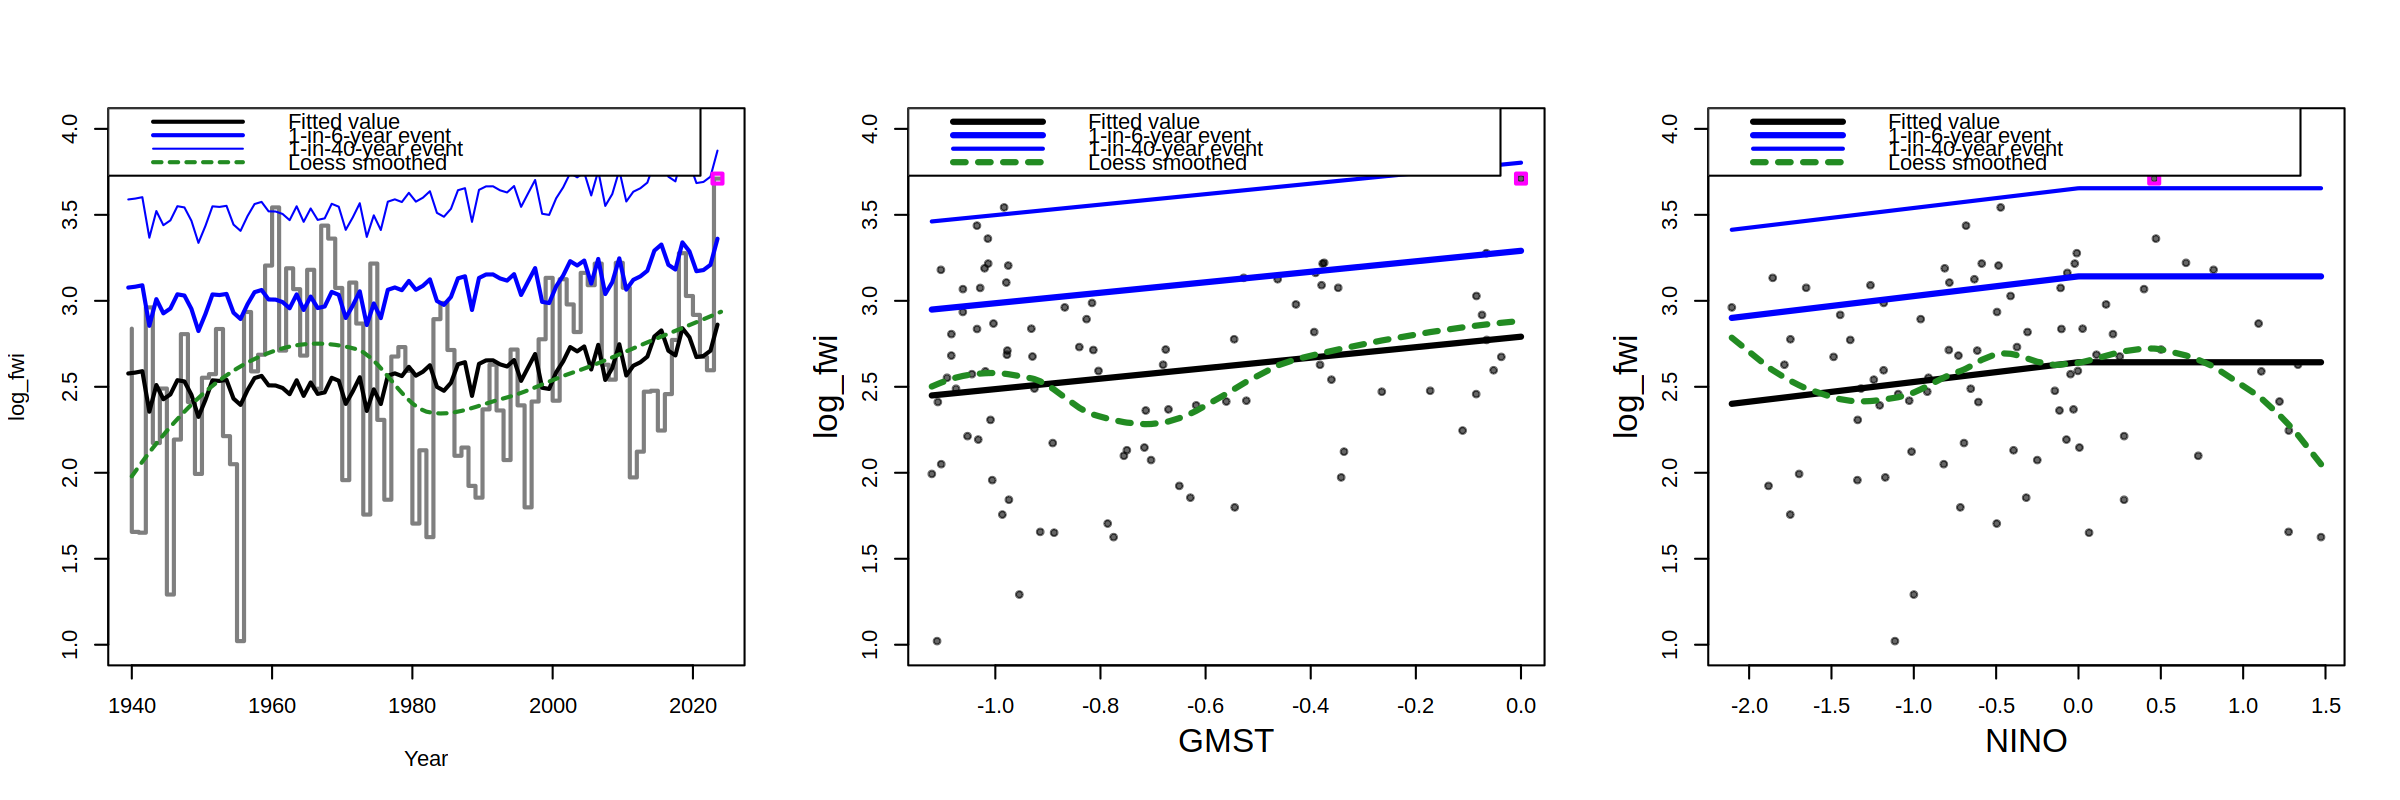

In [49]:
mdl <- mdl_nino[["nino_neg"]]

prep_window(c(1,3))

plot_trend(mdl, add_loess = T)
plot_covtrend(mdl, "gmst", add_loess = T)
plot_covtrend(mdl, "nino", add_loess = T, 
              trend_cov = data.frame(sapply(mdl$covnm, function(cnm) if(cnm == "nneg") {mdl$data[,cnm]} else {mean(mdl$data[,cnm])}, simplify = F)))

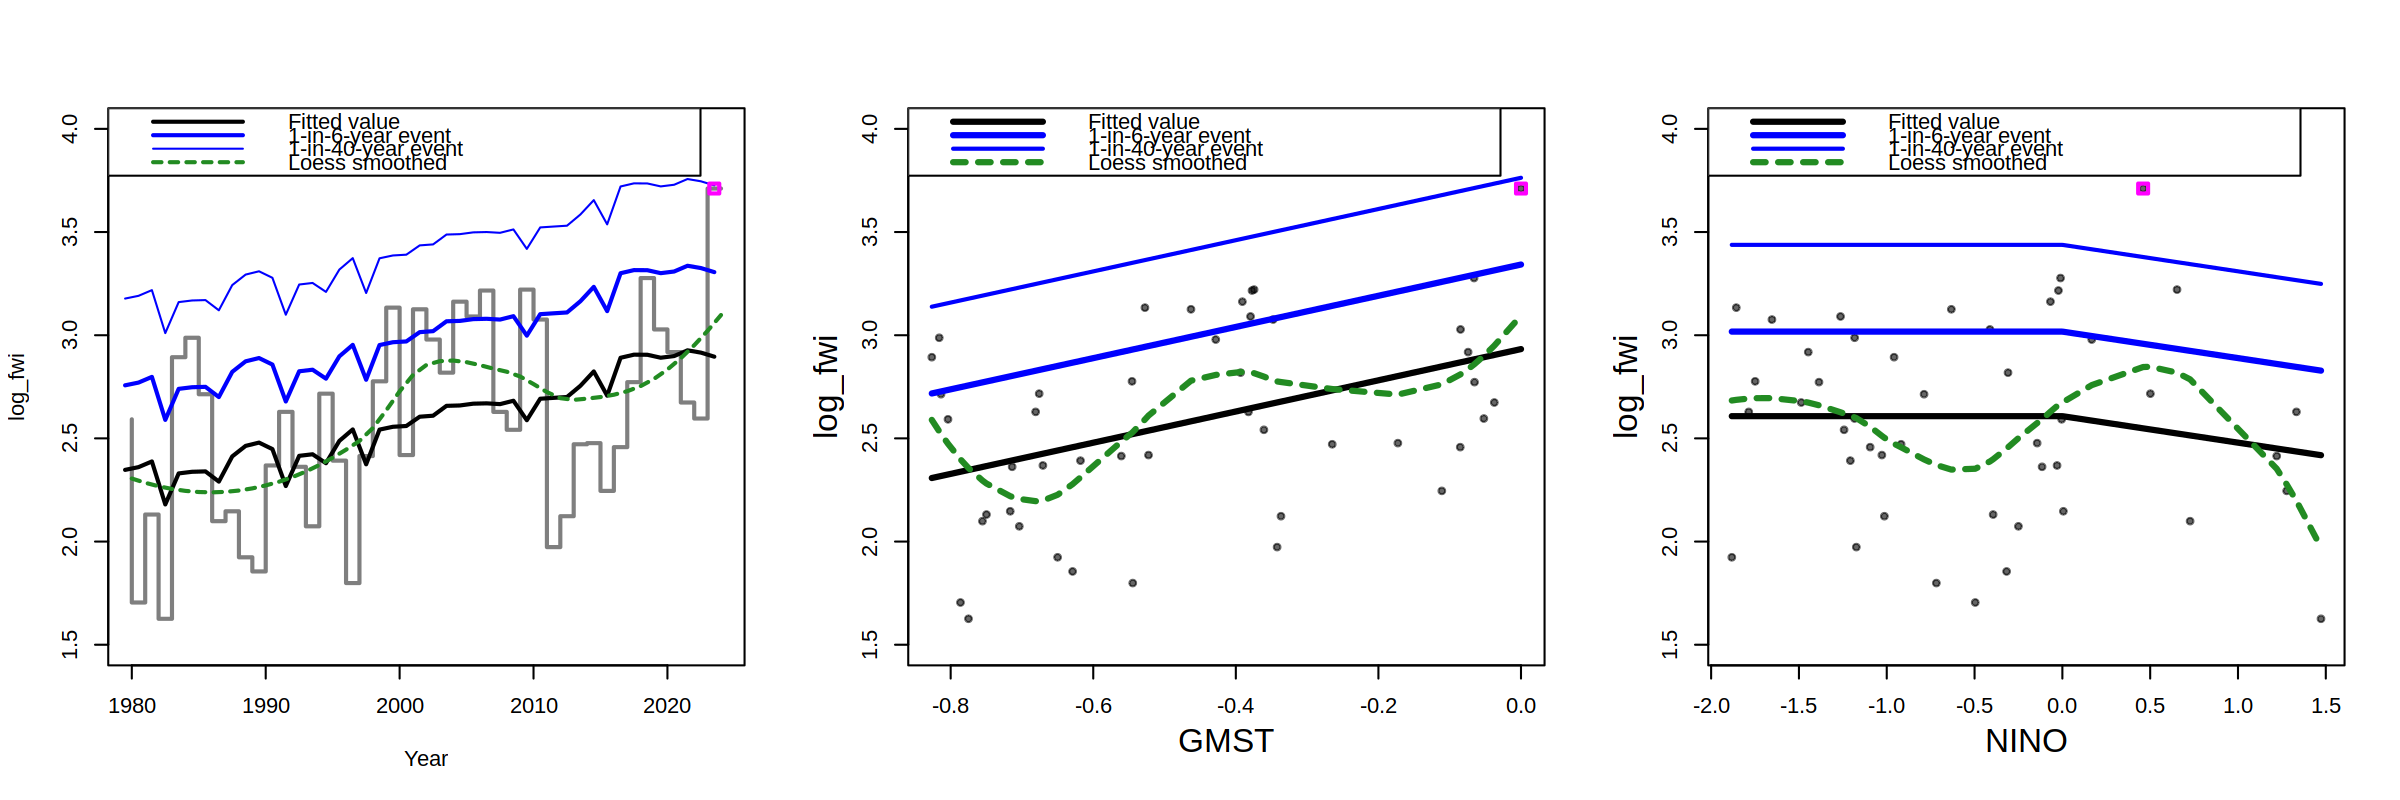

In [42]:
mdl <- mdl_nino[["nino_pos"]]

prep_window(c(1,3))

plot_trend(mdl, add_loess = T)
plot_covtrend(mdl, "gmst", add_loess = T)
plot_covtrend(mdl, "nino", add_loess = T, 
              trend_cov = data.frame(sapply(mdl$covnm, function(cnm) if(cnm == "npos") {mdl$data[,cnm]} else {mean(mdl$data[,cnm])}, simplify = F)))

# Trends in subindices

In [118]:
nino <- load_ts("ts_obs//pantanal-fires_nino-djf_ersst.dat", col.names = c("year", "nino"))

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]


df <- read.csv("ts_obs/df_subindices_june_2000-2024.csv")

df <- merge(merge(gmst, nino), df)

df$log_dmc <- log(df$dufmcode)
df$log_isi <- log(df$infsinx)

In [122]:
si_models <- list("bui" = fit_ns("norm", "shift", df, "fbupinx", c("gmst", "nino")),
                  "log_isi" = fit_ns("norm", "shift", df, "log_isi", c("gmst", "nino")),
                  "dc" = fit_ns("norm", "shift", df, "drtcode", c("gmst", "nino")),
                  "log_dmc" = fit_ns("norm", "shift", df, "log_dmc", c("gmst", "nino")),
                  "ffmc" = fit_ns("norm", "shift", df, "ffmcode", c("gmst", "nino")),
                 "KBDI" = fit_ns("norm", "shift", df, "kbdi", c("gmst", "nino")))

In [124]:
range(df$kbdi)

[1] 11.35155 65.93984

In [125]:
for(i in 1:length(si_models)) {
    
    varnm = names(si_models)[i]
    mdl <- si_models[[i]]
    longnm <- c("build up index", "initial spread index", "drought code", "Duff moisture code", "fine fuel moisture code", "Keetch-Byram drought index")[i]
    
    ylim <- list(c(0,200), c(1,4), c(0,1000), c(2.5,6), c(75,110), c(0,100))[[i]]
    
    png(paste0("fig/fitted-trend_",varnm,".png"), height = 240, width = 360*3); {
        prep_window(c(1,3), oma = c(0,0,1,0))
        
        plot_trend(mdl, add_loess = T, ylim = ylim)
        plot_covtrend(mdl, "gmst", add_loess = T, ylim = ylim)
        plot_covtrend(mdl, "nino", add_loess = T, ylim = ylim)
        
        mtext(paste0("Trends in June ", longnm), outer = T, line = -2)
    }; dev.off()
}   

# Trends in precip & temperature (June)

In [2]:
nino <- load_ts("ts_obs//pantanal-fires_nino-djf_ersst.dat", col.names = c("year", "nino"))

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]


df <- read.csv("ts_obs/df_subsubindices_june_1950-2024.csv")

df <- merge(merge(gmst, nino), df)
df$log_tp <- log(df$tp)

In [3]:
cov_2024 <- df[df$year == 2024,c("gmst", "nino")]
cov_cf <- rbind("hist" = cov_2024 - c(1.2,0), "neut" = c(0,0), "neuthist" = c(-1.2,0))

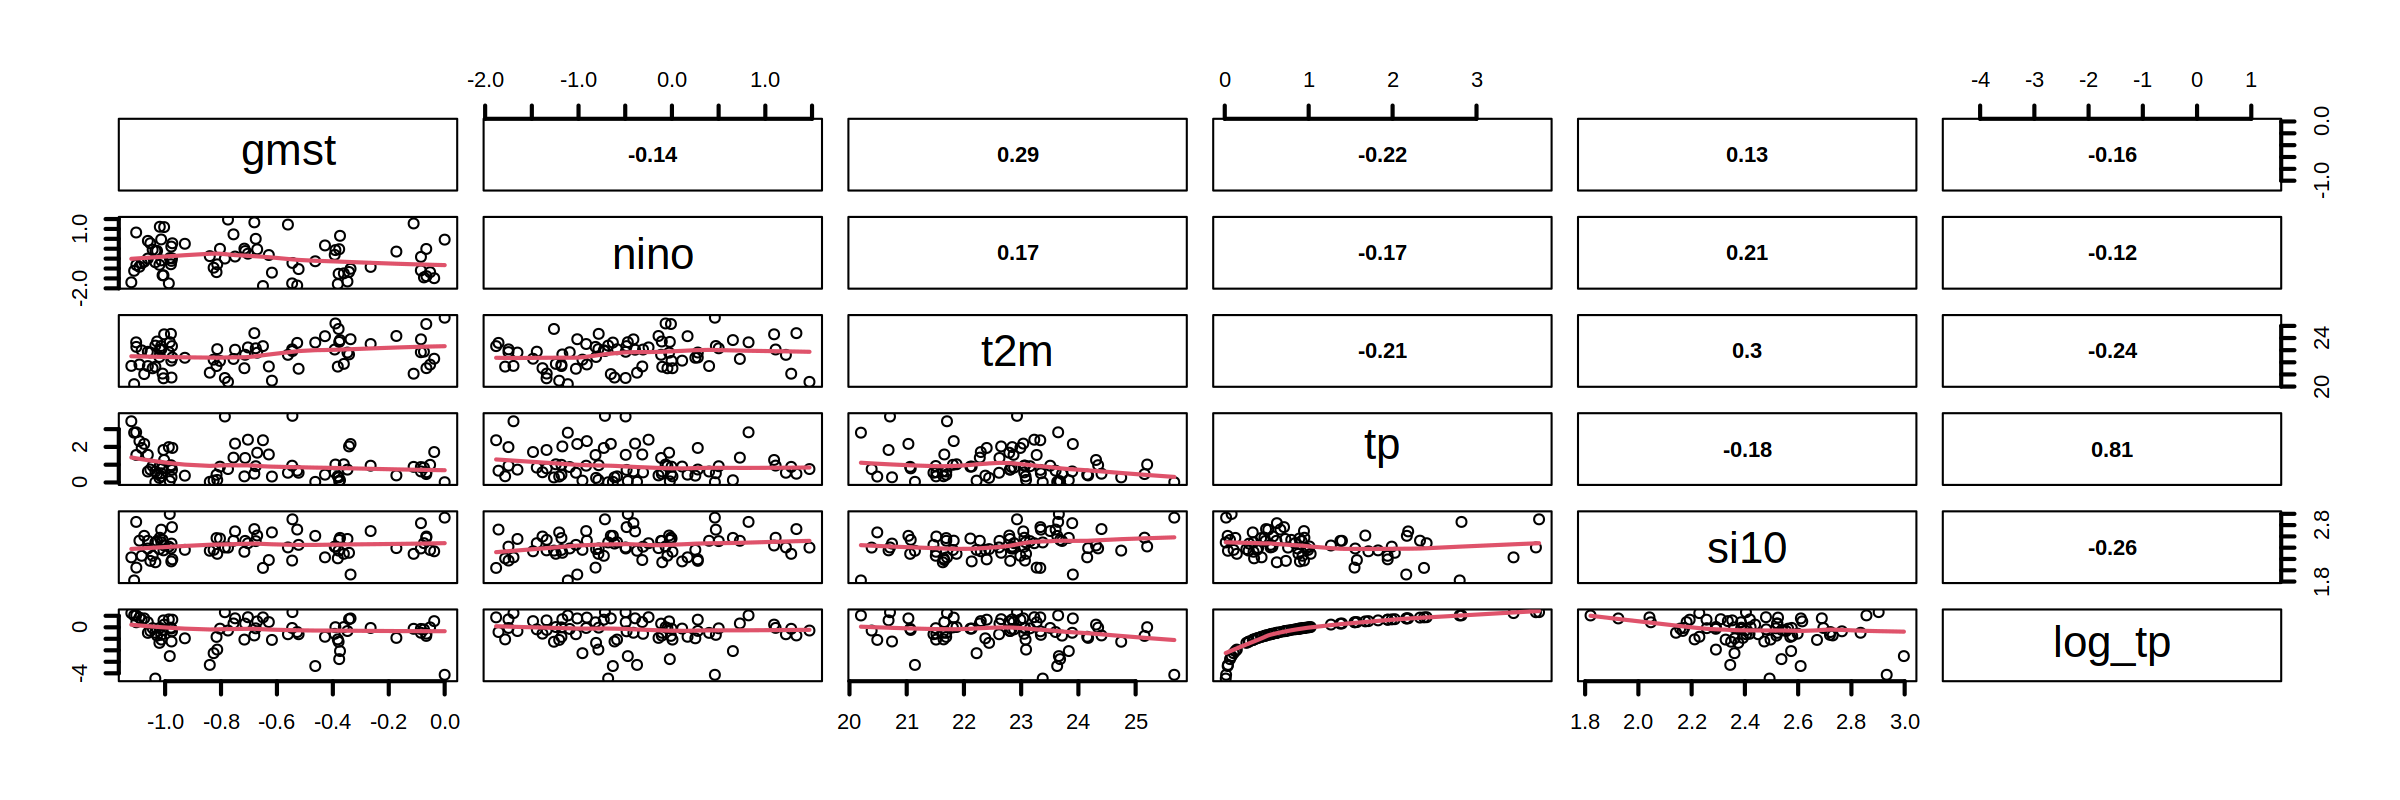

In [251]:
pairs(df[,-1], upper.panel = panel.cor, lower.panel = panel.smooth, lwd = 2)

In [177]:
mdl_t2m <- list("gmst only" = fit_ns("norm", "shift", df, "t2m", c("gmst")),
                "gmst + nino" = fit_ns("norm", "shift", df, "t2m", c("gmst", "nino")))

mdl_tp <- list("gmst only" = fit_ns("norm", "fixeddisp", df, "tp", c("gmst"), lower = T),
                "gmst + nino" = fit_ns("norm", "fixeddisp", df, "tp", c("gmst", "nino"), lower = T))

mdl_ws <- list("gmst only" = fit_ns("norm", "shift", df, "si10", c("gmst"), lower = T),
                "gmst + nino" = fit_ns("norm", "shift", df, "si10", c("gmst", "nino"), lower = T))

mdl_logtp <- list("gmst only" = fit_ns("norm", "shift", df, "log_tp", c("gmst"), lower = T),
                    "gmst + nino" = fit_ns("norm", "shift", df, "log_tp", c("gmst", "nino"), lower = T))

In [178]:
rbind("aic" = sapply(mdl_t2m, aic), sapply(mdl_t2m, rsquared)  * 100)

rbind("aic" = sapply(mdl_tp, aic), sapply(mdl_tp, rsquared)  * 100)
rbind("aic" = sapply(mdl_logtp, aic), sapply(mdl_logtp, rsquared)  * 100)

rbind("aic" = sapply(mdl_ws, aic), sapply(mdl_ws, rsquared)  * 100)



,gmst only,gmst + nino
aic,238.618771,236.70959
r2,8.272500,12.93109
r2.adj,7.015959,10.51251


,gmst only,gmst + nino
aic,192.821268,186.715026
r2,5.027627,10.070471
r2.adj,3.726636,7.572429


,gmst only,gmst + nino
aic,242.886539,243.366002
r2,2.417961,4.376402
r2.adj,1.081221,1.720191


,gmst only,gmst + nino
aic,-8.2353273,-10.320224
r2,1.6008608,6.816864
r2.adj,0.2529274,4.228443


In [183]:
for(i in 1:4) {
    
    varnm = c("tas", "pr", "wspd", "logtp")[i]
    longnm = c("mean temperatures", "precipitation", "wind speed", "log(precip)")[i]
    
    png(paste0("fig/fitted-trend_",varnm,".png"), height = 240, width = 360*3); {
        prep_window(c(1,3), oma = c(0,0,1,0))
        mdl <- list(mdl_t2m, mdl_tp, mdl_ws, mdl_logtp)[[i]][["gmst + nino"]]
        ylim <- list(c(20,28), c(0,6), c(1.5,3.5), c(-6,6))[[i]]

        plot_trend(mdl, add_loess = T, ylim = ylim)
        plot_covtrend(mdl, "gmst", add_loess = T, ylim = ylim)
        plot_covtrend(mdl, "nino", add_loess = T, ylim = ylim)
        
        mtext(paste0("Trends in June ", longnm), outer = T, line = -2)
    }; dev.off()
}   

In [180]:
models <- lapply(list("tas" = mdl_t2m, "pr" = mdl_tp, "log_pr" = mdl_logtp, "ws" = mdl_ws), "[[", "gmst + nino")

In [181]:
sapply(models, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)

,tas,pr,log_pr,ws
mu0,23.5844706,0.588163271,-0.913633684,2.54138359
sigma0,1.1115915,0.454486145,1.162029997,0.21415498
alpha_gmst,1.1062979,-0.392939875,-0.608023052,0.10283694
alpha_nino,0.3111690,-0.135927957,-0.201250587,0.06131500
disp,0.0468481,0.772721057,-1.154888963,0.08334238
event_magnitude,25.6750490,0.016063040,-4.131234298,2.93254020
return_period,25.0695227,9.544556702,279.324334595,1.04717788
PR_hist,24.8034176,1.038474768,7.874637682,0.96612661
dI_abs_hist,1.3275575,-0.019746577,-0.017256654,0.12340433
dI_rel_hist,5.4525433,-55.143222925,-51.791154387,4.39296406


# Trends in precip & temperature (May-June)

In [109]:
nino <- load_ts("ts_obs//pantanal-fires_nino-djf_ersst.dat", col.names = c("year", "nino"))

gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]


df <- read.csv("data/era5_variables_may-june.csv")

df <- merge(merge(gmst, nino), df)
df$log_tp <- log(df$tp)

In [110]:
cov_2024 <- df[df$year == 2024,c("gmst", "nino")]
cov_cf <- rbind("hist" = cov_2024 - c(1.2,0), "neut" = c(0,0), "neuthist" = c(-1.2,0))

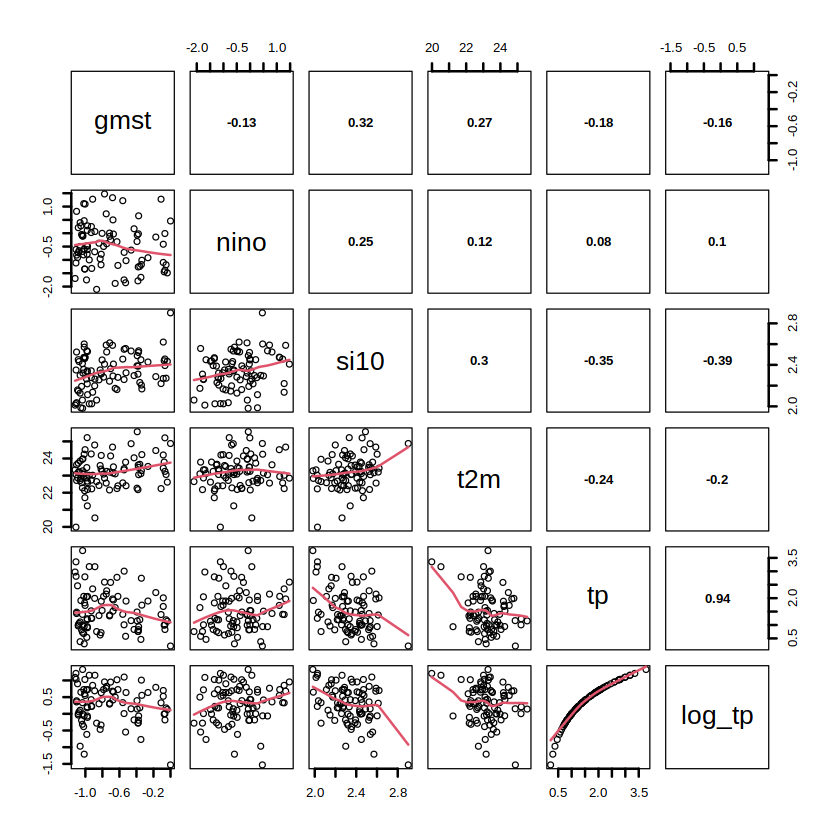

In [111]:
pairs(df[,-1], upper.panel = panel.cor, lower.panel = panel.smooth, lwd = 2)

In [112]:
mdl_t2m <- list("gmst only" = fit_ns("norm", "shift", df, "t2m", c("gmst")),
                "gmst + nino" = fit_ns("norm", "shift", df, "t2m", c("gmst", "nino")))

mdl_tp <- list("gmst only" = fit_ns("norm", "fixeddisp", df, "tp", c("gmst"), lower = T),
                "gmst + nino" = fit_ns("norm", "fixeddisp", df, "tp", c("gmst", "nino"), lower = T))

mdl_ws <- list("gmst only" = fit_ns("norm", "shift", df, "si10", c("gmst"), lower = T),
                "gmst + nino" = fit_ns("norm", "shift", df, "si10", c("gmst", "nino"), lower = T))

mdl_logtp <- list("gmst only" = fit_ns("norm", "shift", df, "log_tp", c("gmst"), lower = T),
                    "gmst + nino" = fit_ns("norm", "shift", df, "log_tp", c("gmst", "nino"), lower = T))

In [113]:
rbind("aic" = sapply(mdl_t2m, aic), sapply(mdl_t2m, rsquared)  * 100)

rbind("aic" = sapply(mdl_tp, aic), sapply(mdl_tp, rsquared)  * 100)
rbind("aic" = sapply(mdl_logtp, aic), sapply(mdl_logtp, rsquared)  * 100)

rbind("aic" = sapply(mdl_ws, aic), sapply(mdl_ws, rsquared)  * 100)



,gmst only,gmst + nino
aic,231.537801,231.255286
r2,7.237015,9.694843
r2.adj,6.119389,7.492278


,gmst only,gmst + nino
aic,197.666375,199.6647191
r2,2.809025,2.8386728
r2.adj,1.638050,0.4688843


,gmst only,gmst + nino
aic,145.588486,147.052879
r2,2.453717,3.066448
r2.adj,1.278460,0.702215


,gmst only,gmst + nino
aic,-57.379241,-63.88799
r2,10.442489,18.97336
r2.adj,9.363483,16.99710


In [114]:
for(i in 1:4) {
    
    varnm = c("tas", "pr", "wspd", "logtp")[i]
    longnm = c("mean temperatures", "precipitation", "wind speed", "log(precip)")[i]
    
    png(paste0("fig/fitted-trend_mayjune_",varnm,".png"), height = 240, width = 360*3); {
        prep_window(c(1,3), oma = c(0,0,1,0))
        mdl <- list(mdl_t2m, mdl_tp, mdl_ws, mdl_logtp)[[i]][["gmst + nino"]]
        ylim <- list(c(20,28), c(0,6), c(1.5,3.5), c(-6,6))[[i]]

        plot_trend(mdl, add_loess = T, ylim = ylim)
        plot_covtrend(mdl, "gmst", add_loess = T, ylim = ylim)
        plot_covtrend(mdl, "nino", add_loess = T, ylim = ylim)
        
        mtext(paste0("Trends in May-June ", longnm), outer = T, line = -2)
    }; dev.off()
}   

In [115]:
models <- lapply(list("tas" = mdl_t2m, "pr" = mdl_tp, "log_pr" = mdl_logtp, "ws" = mdl_ws), "[[", "gmst + nino")

In [116]:
sapply(models, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)

# Gamma distribution for precip?

[1] 29.91585

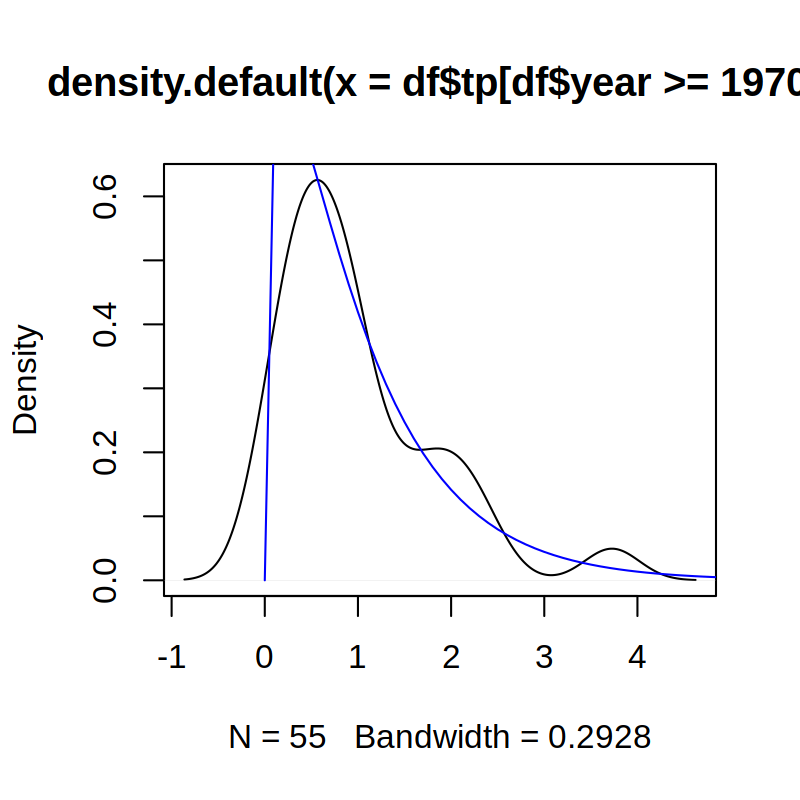

In [212]:
fitted.gamma = fitdist(df$tp[df$year >=1970], "gamma")
plot(density(df$tp[df$year >=1970]))
x <- seq(0,5,0.1)
lines(x, dgamma(x, shape = fitted.gamma$est["shape"], rate = fitted.gamma$est["rate"]), col = "blue")

# return period ~ 30 years
1/qgamma(df$tp[df$year == 2024], shape = fitted.gamma$est["shape"], rate = fitted.gamma$est["rate"])

summary statistics
------
min:  0.01606304   max:  3.745426 
median:  0.7922938 
mean:  0.9947416 
estimated sd:  0.8442081 
estimated skewness:  1.450552 
estimated kurtosis:  5.279744 

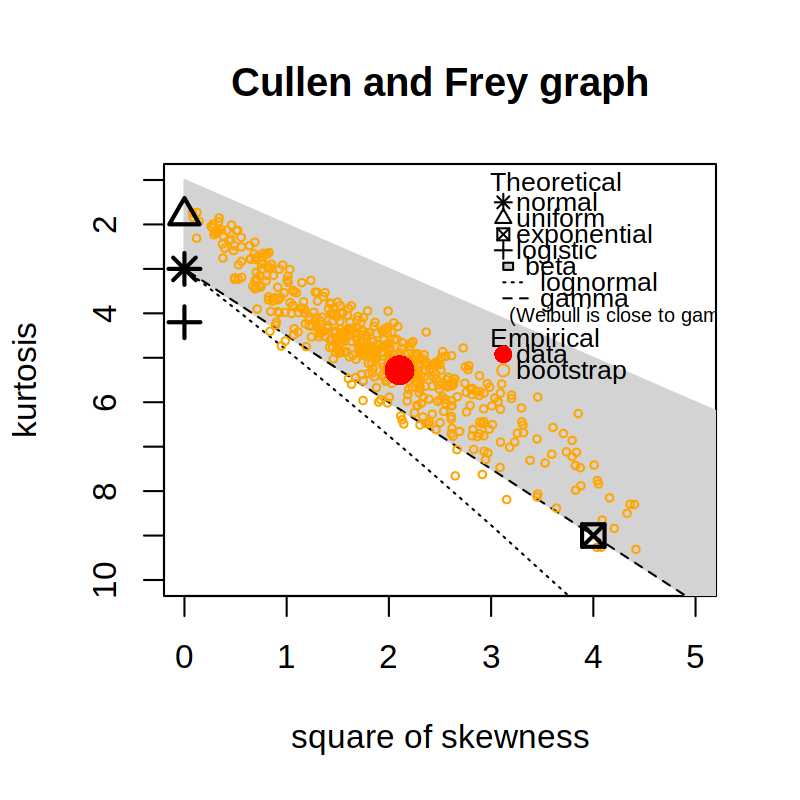

In [208]:
prep_window(c(1,1))
fitdistrplus::descdist(df$tp[df$year >=1970], discrete=FALSE, boot=500)

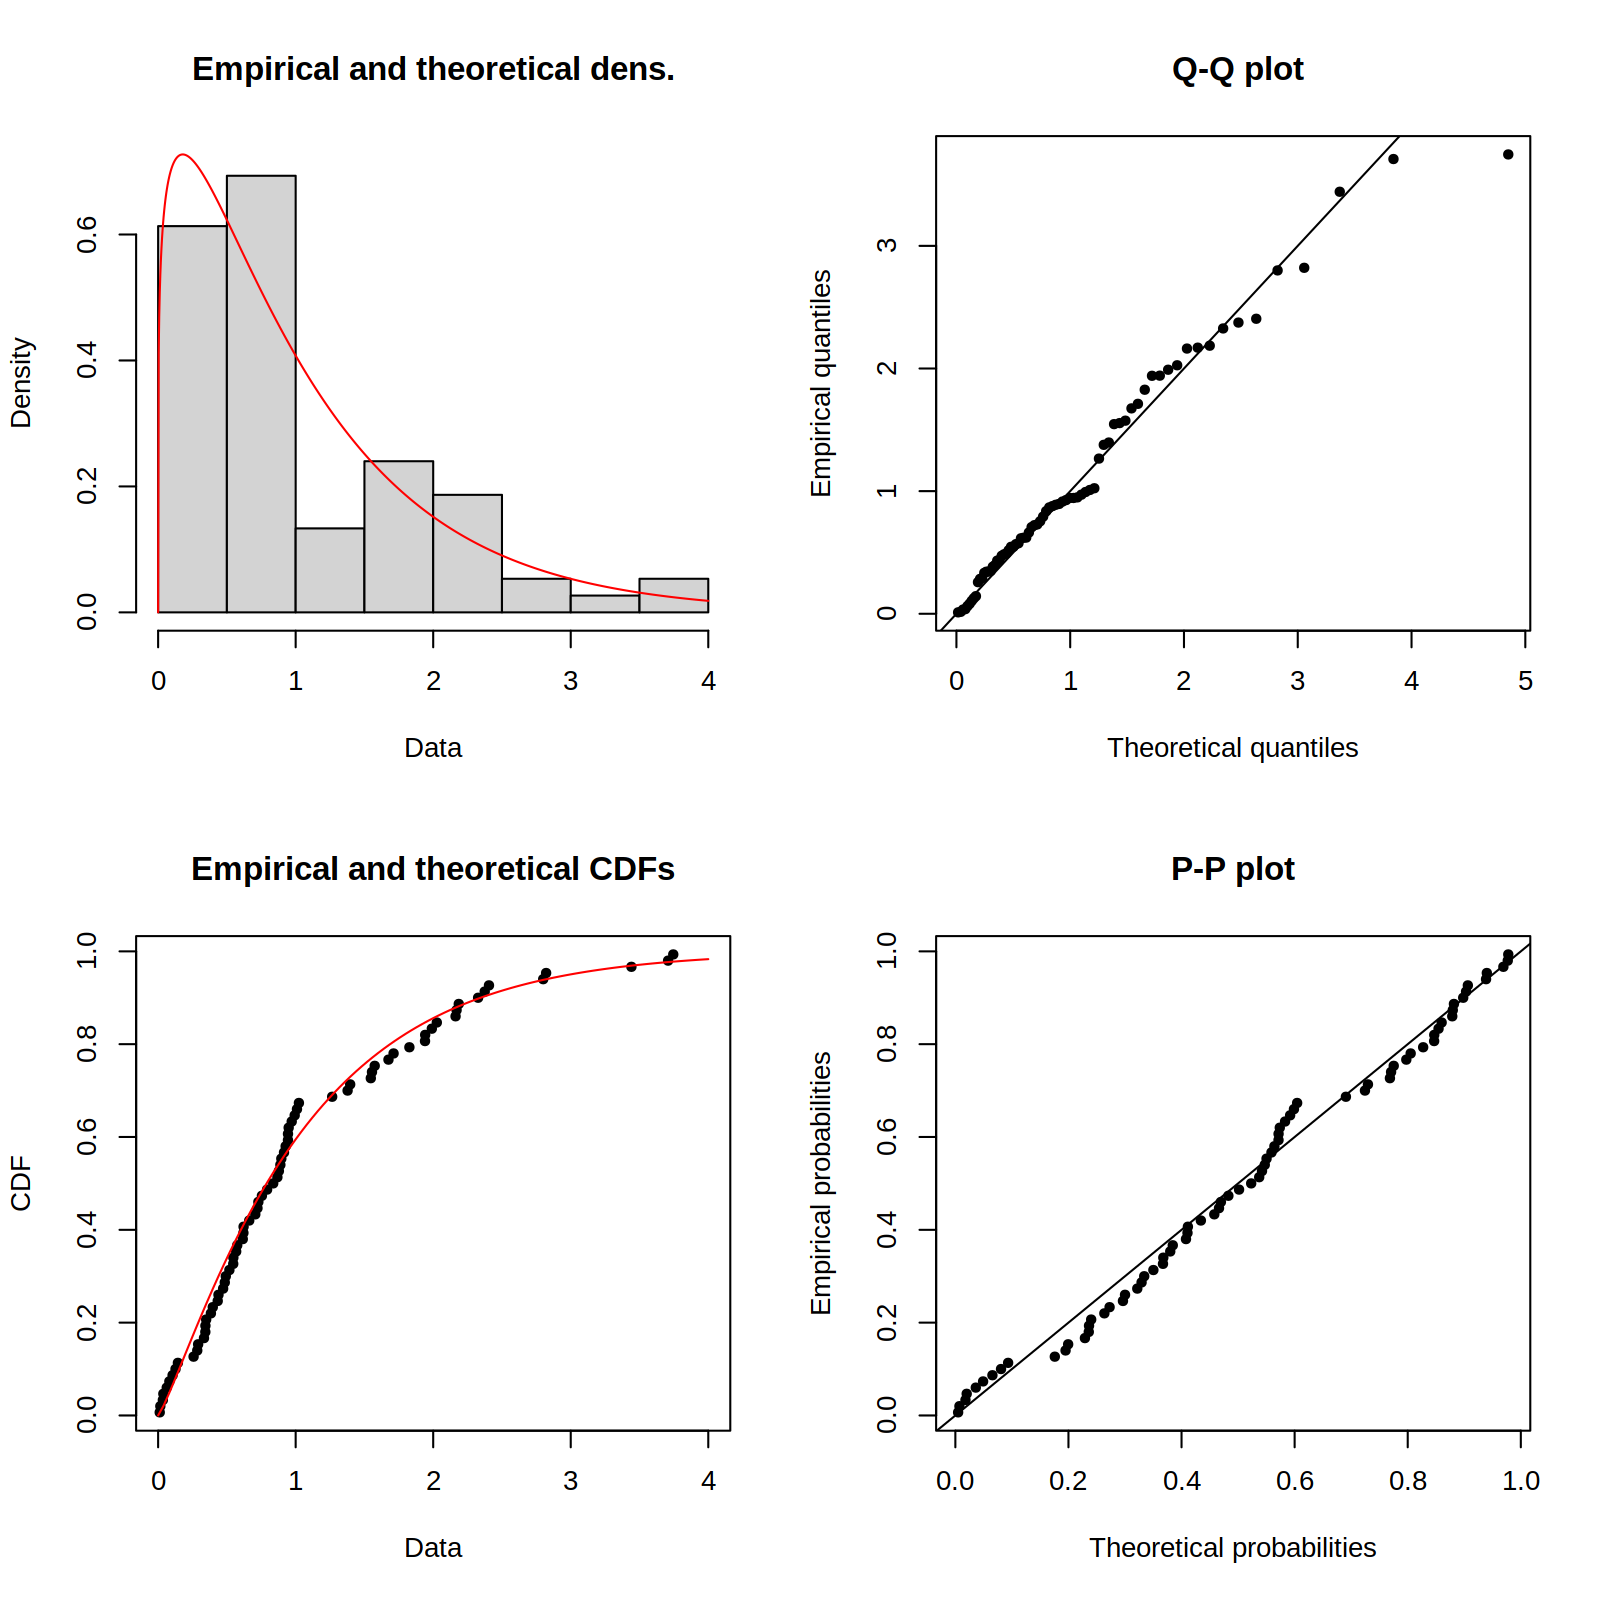

In [206]:
prep_window(c(2,2))
plot(fitted.gamma)

# Trend in DSR

In [114]:
gmst <- read.table("ts_obs/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

cov_2024 <- data.frame(gmst = 0)
cov_cf <- data.frame(gmst = c("pi" = -1.2, "2000" = -0.5))

In [227]:
datasets <- sapply(list("era5" = "era5", "era5_1979" = "era5-1979", "mswx" = "mswx", "merra2" = "merra2-corrected"),
                  function(ds) load_ts(paste0("ts_obs/pantanal-fires_dsr-june_",ds,".dat"), col.names = c("year", "dsr")), simplify = F)

datasets <- sapply(datasets, function(df) {df["l_dsr"] = log10(df$dsr); return(df)}, simplify = F)

In [228]:
models <- sapply(datasets, function(df) fit_ns("norm", "shift", merge(gmst, df), "l_dsr", c("gmst"), lower = F), simplify = F)

In [229]:
# MERRA2 doesn't have June 2024 yet - fix the event value as a 30-year event in 2024
models[["merra2"]]$ev <- eff_return_level(models[["merra2"]], 35, fixed_cov = cov_2024); models[["merra2"]]$ev_year <- 2024; models[["merra2"]]$ev_idx <- nrow(datasets[["merra2"]])

## Check log-normality

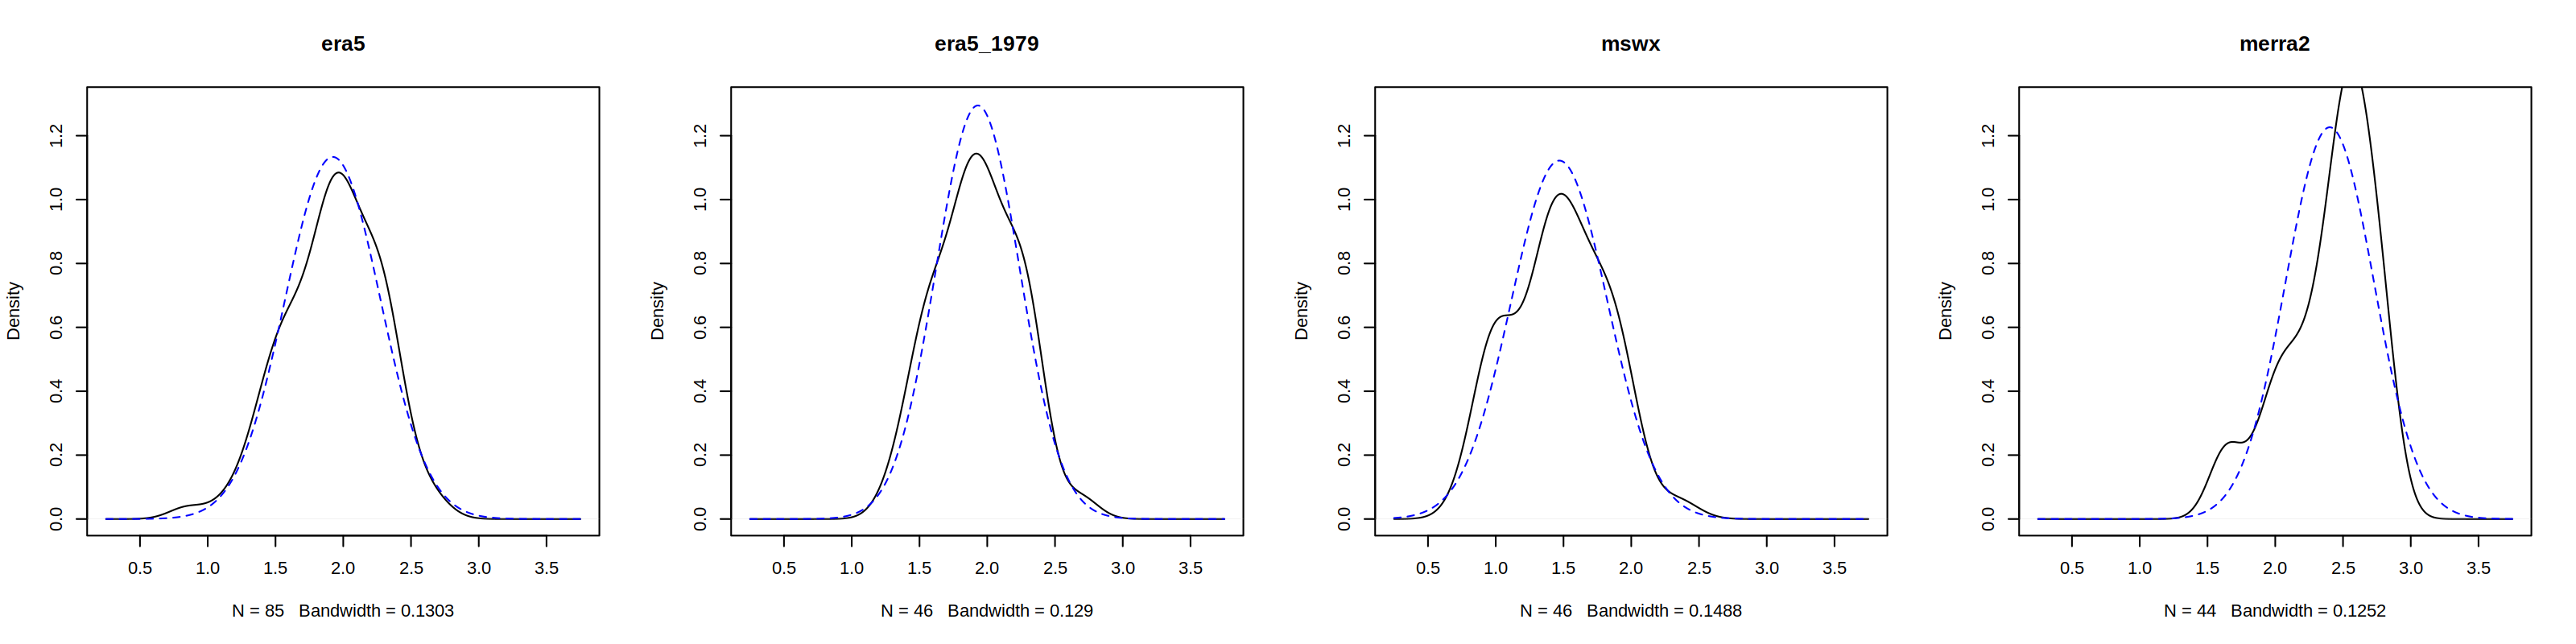

In [232]:
prep_window(c(1,4))

xlim <- c(0.25,3.75)
ylim <- c(0,1.3)
x <- seq(xlim[1],xlim[2],0.01)

for (i in 1:4) {

    ts <- log10(datasets[[i]]$dsr)
    plot(density(ts, from = xlim[1], to = xlim[2]), ylim = ylim, xlim = xlim, main = names(datasets)[i])
    lines(x, dnorm(x, mean(ts), sd(ts)), col = "blue", lty = 2)
}

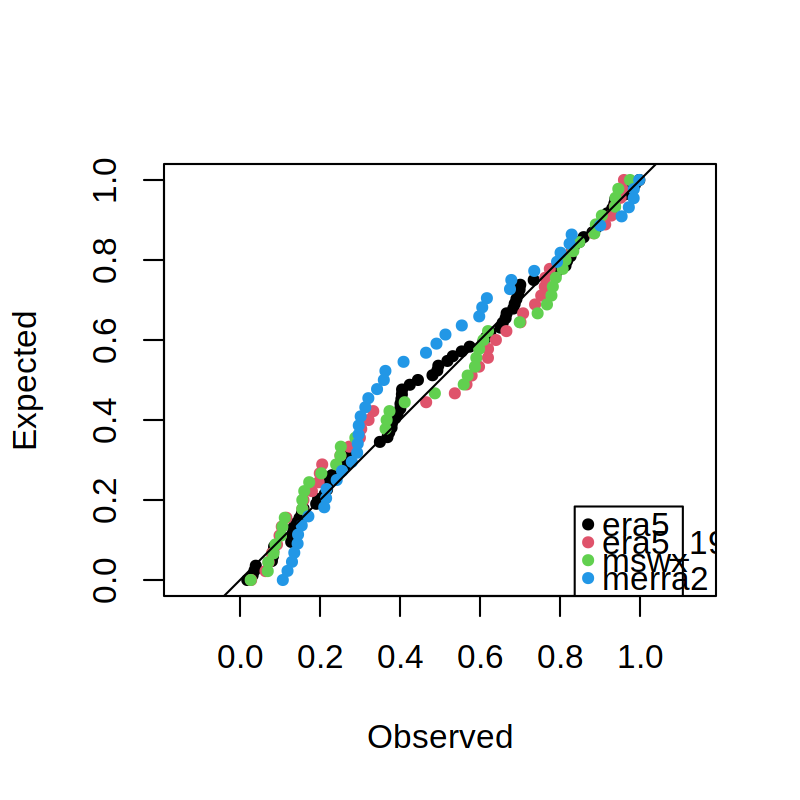

In [31]:
prep_window(c(1,1))

plot(0, type = "n", xlim = c(0,1), ylim = c(0,1), asp = T, xlab = "Observed", ylab = "Expected")    
for (i in 1:length(models)) {

        mdl <- models[[i]]
        points(sort(map_to_u(mdl)), seq(0,1,length.out = length(mdl$x)), col = i)
    }
abline(0,1)
legend("bottomright", legend = names(models), col = 1:4, pch = 20)

## Quick model results

In [233]:
qres <- sapply(models, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)[c("return_period", "PR_pi", "PR_2000"),]

rl2024 <- sapply(models, function(mdl) eff_return_level(mdl, mdl$ev, fixed_cov = cov_2024))
rl2000 <- sapply(models, function(mdl) eff_return_level(mdl, mdl$ev, fixed_cov = cov_cf["2000",,drop = F]))
rlpi <- sapply(models, function(mdl) eff_return_level(mdl, mdl$ev, fixed_cov = cov_cf["pi",,drop = F]))

qres <- rbind(qres, "dI_rel_pi" = ((rl2024-rlpi) / rlpi) * 100, "dI_rel_2000" = ((rl2024-rl2000) / rl2000) * 100)

In [234]:
round(qres,1)

,era5,era5_1979,mswx,merra2
return_period,31.7,35.9,37.4,35.0
PR_pi,4.7,1059.2,673.0,121.8
PR_2000,1.8,10.9,9.6,5.6
dI_rel_pi,10.9,35.5,57.3,21.6
dI_rel_2000,4.3,12.2,17.9,8.0


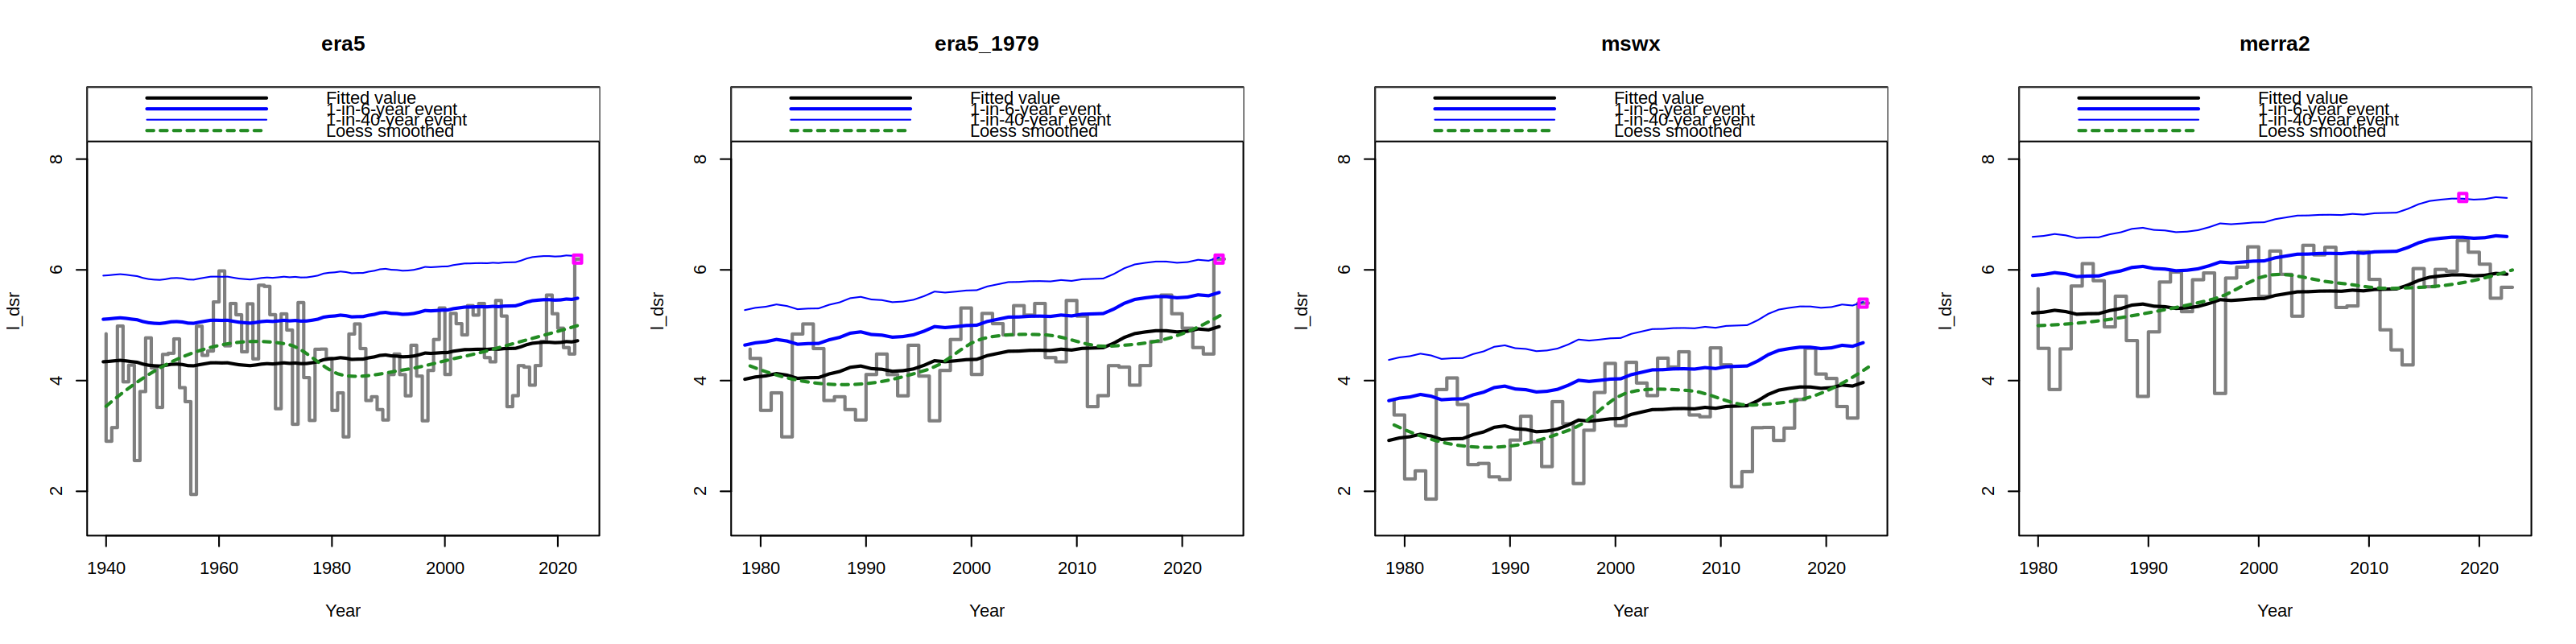

In [149]:
nm <- length(models)
ylim <- c(1.5,9)

png("fig/fitted-trend_logdsr.png", height = 240, width = 360 * 3); {
    prep_window(c(1,nm))

    for(i in 1:nm) {
        mdl <- models[[i]]
        plot_trend(mdl, ylim = ylim, main = names(models)[i], add_loess = T)
    }
}; dev.off()

In [184]:
png("fig/fitted-trend_dsr.png", height = 240, width = 360 * 3); {
    prep_window(c(1,nm))
    ylim = c(0,700) 
    for(i in 1:nm) {
        mdl <- models[[i]]
        df <- mdl$data
        c <- (df$dsr^{1/df$l_dsr})[1]
        plot(df$year, df$dsr, type = "S", main = names(models)[i], ylim = ylim)
        points(2024, c^mdl$ev, col = "magenta", pch = 0, lwd = 2)
        lines(df$year, fitted(loess(dsr ~ year, df)), col = "forestgreen", lty = 2)
        lines(df$year, c^ns_pars(mdl)$loc, lwd = 2)
        lines(df$year, c^eff_return_level(mdl, 6), lwd = 2, col = "blue")
        lines(df$year, c^eff_return_level(mdl, 40), lwd = 1, col = "blue")
    }
}; dev.off()

png 
  2

In [206]:
png("fig/fitted-gmsttrend_logdsr.png", height = 240, width = 360 * 3); {
    prep_window(c(1,nm))
    ylim = c(0,700) 
    
    for(i in 1:nm) {
        mdl <- models[[i]]
        plot_covtrend(mdl, "gmst", ylim = ylim, main = names(models)[i], add_loess = T)
    }
}; dev.off()


png 
  2

In [183]:
png("fig/fitted-gmsttrend_dsr.png", height = 240, width = 360 * 3); {
    prep_window(c(1,nm))
    ylim = c(0,2000) 
    for(i in 1:nm) {
        mdl <- models[[i]]
        df <- mdl$data[order(mdl$data$gmst),]
        c <- (df$dsr^{1/df$l_dsr})[1]
        plot(df$gmst, df$dsr, main = names(models)[i], ylim = ylim)
        points(0, c^mdl$ev, col = "magenta", pch = 0, lwd = 2)
        lines(df$gmst, fitted(loess(dsr ~ gmst, df)), col = "forestgreen", lty = 2)
        lines(df$gmst, c^ns_pars(mdl, fixed_cov = df[,"gmst",drop = F])$loc, lwd = 2)
        lines(df$gmst, c^eff_return_level(mdl, 6, fixed_cov = df[,"gmst",drop = F]), lwd = 2, col = "blue")
        lines(df$gmst, c^eff_return_level(mdl, 40, fixed_cov = df[,"gmst",drop = F]), lwd = 1, col = "blue")
    }
}; dev.off()

png 
  2

In [205]:
png("fig/fitted-returnlevels_logdsr.png", height = 240, width = 360 * 3); {
    prep_window(c(1,nm))

    for(i in 1:nm) {
        mdl <- models[[i]]
        plot_returnlevels(mdl, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop = F], ylim = c(1,9), main = names(models)[i], legend_pos = "bottomright")
    }
}; dev.off()

png 
  2

## Quick model results excluding 2024

In [201]:
sapply(models, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)

,era5,era5_1979,mswx,merra2
mu0,4.7195626,4.9748789,3.9660019,5.9703875
sigma0,0.7938918,0.6372902,0.7421874,0.7026561
alpha_gmst,0.4076740,1.1313464,1.2463384,0.9341853
disp,0.1682130,0.1281016,0.1871374,0.1176902
event_magnitude,6.1945563,6.1945563,5.3990288,5.6845586
return_period,31.6559464,35.9457453,37.3790722,1.5199498
PR_pi,4.7305463,1059.5014552,673.1583387,5.6091262
dI_abs_pi,0.4892088,1.3576156,1.4956060,1.1210224
dI_rel_pi,8.5745660,28.0676511,38.3152453,24.5647749
PR_2000,1.8335763,10.9375557,9.5583426,1.6521630


In [202]:
models_excl <- sapply(datasets, function(df) fit_ns("norm", "shift", merge(gmst, df[df$year < 2024,]), "l_dsr", c("gmst"), lower = F), simplify = F)
sapply(models_excl, mdl_ests, cov_f = cov_2024, cov_cf = cov_cf)

,era5,era5_1979,mswx,merra2
mu0,4.6157035,4.8509917,3.8204169,5.9703875
sigma0,0.7810528,0.6154255,0.7161084,0.7026561
alpha_gmst,0.2888132,0.9289203,1.0084412,0.9341853
disp,0.1692164,0.1268659,0.1874425,0.1176902
event_magnitude,4.4800464,4.4800464,3.3226729,5.6845586
return_period,1.7576439,1.3761573,1.3218882,1.5199498
PR_pi,1.4456219,6.4067005,4.7305538,5.6091262
dI_abs_pi,0.3465759,1.1147044,1.2101294,1.1210224
dI_rel_pi,8.3846223,33.1230642,57.2830555,24.5647749
PR_2000,1.1481490,1.6529582,1.5239845,1.6521630


In [194]:
rl2024 <- sapply(models, function(mdl) eff_return_level(mdl, mdl$ev, fixed_cov = cov_2024))
rl2000 <- sapply(models, function(mdl) eff_return_level(mdl, mdl$ev, fixed_cov = cov_cf["2000",,drop = F]))
rlpi <- sapply(models, function(mdl) eff_return_level(mdl, mdl$ev, fixed_cov = cov_cf["pi",,drop = F]))

qres <- rbind(qres, "dI_rel_pi" = ((rl2024-rlpi) / rlpi) * 100, "dI_rel_2000" = ((rl2024-rl2000) / rl2000) * 100)

In [195]:
round(qres,1)

,era5,era5_1979,mswx,merra2
return_period,31.7,35.9,37.4,35.0
PR_pi,4.7,1059.5,673.2,121.7
PR_2000,1.8,10.9,9.6,5.6
dI_rel_pi,9.8,32.0,47.7,20.0
dI_rel_2000,3.8,11.2,15.5,7.4
dI_rel_pi,7.1,26.5,40.6,20.4
dI_rel_2000,2.9,9.6,13.7,7.6
dI_rel_pi,7.1,26.5,40.6,20.4
dI_rel_2000,2.9,9.6,13.7,7.6


## Bootstrapped model results

In [247]:
for(mnm in names(models)) {
    mdl = models[[mnm]]
    df <- mdl$data
    res <- boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_cf)
    write.csv(res, paste0("res/res-obs_logdsr_",mnm,".csv"))
}